In [1]:
from __future__ import print_function
import numpy as np
import torch
import torch.autograd as ag
import mnist_reader
import MNISTtools
import matplotlib.pyplot as plt
import time
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import data_split
import gc
import utils
import copy

In [2]:
# Can also add data augmentation transforms here
train_transform = transforms.Compose([#transforms.Resize(224), 
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(), 
                                      transforms.Lambda(lambda x: torch.cat([x,x,x],0)) ])

# transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   #transforms.ToPILImage(),
test_transform = transforms.Compose([ transforms.Resize(224), 
                                     transforms.ToTensor(), transforms.Lambda(lambda x: torch.cat([x,x,x],0)) ])

In [3]:
# print('Downloading/Checking for data......')
trainset = torchvision.datasets.FashionMNIST(root='data/downloads', train=True,
                                        download=True, transform=train_transform)       # download=True for the 1st time
testset = torchvision.datasets.FashionMNIST(root='data/downloads', train=False,
                                        download=True, transform=test_transform)        # download=True for the 1st time
train, validation = data_split.train_valid_split(trainset)    # separates 10% for validation

In [4]:
trainloader = torch.utils.data.DataLoader(train, batch_size=40, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validation, batch_size=40, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=40, shuffle=False, num_workers=2)

In [5]:
print('# of batches in training: ',len(trainloader), ',   Total train data: ',len(trainloader)*40)
print('# of batches in test: ',len(testloader), ',   Total test data: ',len(testloader)*40)
img, label = train[100]
print('image size: ', img.size())
# plt.imshow(img[0,:,:], cmap='gray')
# print(type(label))

# of batches in training:  1350 ,   Total train data:  54000
# of batches in test:  250 ,   Total test data:  10000
image size:  torch.Size([3, 224, 224])


# Loading the VGG16 trained on imagenet

In [6]:
vgg16 = torchvision.models.vgg16_bn(pretrained='imagenet')
# print(vgg16.classifier[6].out_features)        # 1000, as it was trained for 1000 classes

#--------------------------------------------------------------------------------------
# REMEMBER: vgg16.features --> convolutional layers, vgg16.classifier --> FC layers
#--------------------------------------------------------------------------------------

# freeze all parameters in covolutional layers
for parameter in vgg16.features.parameters():
    parameter.require_grad = False

in_ftrs = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]       # Removing last layer to add out 10 units layer
# features.extend([nn.Linear(in_ftrs, 128), nn.ReLU(True),\
#                     nn.Dropout(p=0.5), nn.Linear(128,10)])      
features.extend([nn.Linear(in_ftrs, 10)])                # adding out layer with 10 units
vgg16.classifier = nn.Sequential(*features)             # replacing it with the model with new last layer

In [7]:
# print(vgg16)  # prints the architecture

In [8]:
vgg16=vgg16.cuda()

In [10]:
def test(vgg16, dataloader, compute_loss=False, criterion=None):
    correct = 0
    total = 0
    acc_test = 0.0
    total_loss = 0.0
    
    vgg16.train(False)
    vgg16.eval()    
    for i,data in enumerate(dataloader):
        images, labels = data

        images = images.cuda()
        labels = labels.cuda()

        images = ag.Variable(images, volatile=True)
        labels = ag.Variable(labels, volatile=True)

        outputs = vgg16(images)
        
        if compute_loss:
            loss = criterion(outputs, labels)
            total_loss += loss.data[0]
        
        _, predicted = torch.max(outputs.data, 1)
        acc_test += torch.sum(predicted == labels.data)
        total += len(labels.data)
        del outputs, predicted, images, labels
        torch.cuda.empty_cache()
    #     gc.collect()

    print(acc_test/total)
    # print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))
    return acc_test*1.0/total, total_loss*1.0/total

In [10]:
# test(vgg16)

In [14]:
def to_file(valid_accs, train_loss_list, valid_loss_list, epoch, best_epoch):
    utils.write_list_to_file('assets/validation_accuracies.txt', valid_accs)
    utils.write_list_to_file('assets/train_loss_list_epoch_'+str(epoch)+'.txt', train_loss_list)
    utils.write_list_to_file('assets/validation_losses.txt', valid_loss_list)
    utils.write_list_to_file('assets/best_epoch.txt', [best_epoch])

# Training the model

In [12]:
vgg16.train(True)
# vgg16.train()
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(vgg16.parameters(),lr = 0.001, weight_decay=5e-4)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
start=time.time()
best_acc=0.0
best_model=None
best_epoch=1
valid_accs=[]
valid_loss_list=[]

for epoch in range(4,8):  # loop over the dataset multiple times
    vgg16.train(True)
    running_loss = 0.0
    train_loss_list=[]
    
    for i, data in enumerate(trainloader, 0):       # 0 is just to start i from 0
        # get the inputs
        inputs, labels = data
        
        inputs = ag.Variable(inputs, requires_grad = False)
        labels = ag.Variable(labels, requires_grad = False)
        
        # transformations
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg16(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        curr_loss = loss[0].data.cpu().numpy()[0]
        # curr_loss = loss.data[0]
        running_loss += curr_loss
        train_loss_list.append(curr_loss)
        # print(type(loss[0].data.cpu().numpy()[0]))
        if i==50:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 50))
        if i==100:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
        if i==200:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 200))
        
        if i % 500 == 499:    # print every 500 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 500))
            running_loss = 0.0
        del inputs, labels, loss, outputs
        torch.cuda.empty_cache()
        
    valid_acc, avg_valid_loss=test(vgg16, validloader,True, criterion)
    valid_accs.append(valid_acc)
    valid_loss_list.append(avg_valid_loss)
    
    if valid_acc > best_acc:                                          # check for best model
        best_acc = valid_acc
        best_model = copy.deepcopy(vgg16.state_dict())
        best_epoch = epoch+1
        torch.save(best_model, 'assets/VGG16_aug_best_model_after_3epochs.pt')      # save best model
        
    to_file(valid_accs, train_loss_list, valid_loss_list, epoch+1, best_epoch)
    print('epoch: ', epoch+1)
    print('valid acc: ', valid_acc)
    print('Total time taken in training (secs): ',time.time()-start)
print('Total time taken in training (secs): ',time.time()-start)
print('Finished Training')

[5,    51] loss: 0.499
[5,   101] loss: 0.477
[5,   201] loss: 0.471
[5,   500] loss: 0.478


In [ ]:
# t=str(time.strftime("%c"))
# utils.write_list_to_file('assets/list_' + str(time.strftime("%c")) + '.txt', l)

# Saving the model (very important)

In [15]:
# torch.save(vgg16.state_dict(), 'VGG16_7epochs_40minibatch_new.pt')

In [28]:
torch.cuda.empty_cache()

# Load the saved model
To load a saved model and test it on the test set

In [6]:
# load the architecture's skeleton
vgg16 = torchvision.models.vgg16_bn(pretrained=False)
for parameter in vgg16.features.parameters():
    parameter.require_grad = False

in_ftrs = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1]       # Removing last layer to add out 10 units layer
features.extend([nn.Linear(in_ftrs, 10)])                # adding out layer with 10 units
vgg16.classifier = nn.Sequential(*features)

In [18]:
# # load the saved model
vgg16.load_state_dict(torch.load('assets/VGG16_aug_best_model_after_2epochs.pt'))
vgg16 = vgg16.cuda()

In [19]:
test(vgg16, testloader)

0.9097


(0.9097, 0.0)

Training Loss

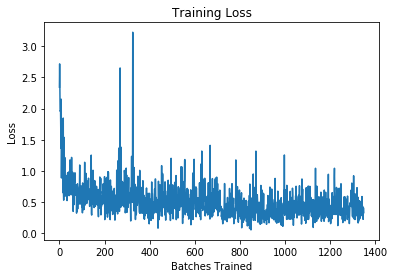

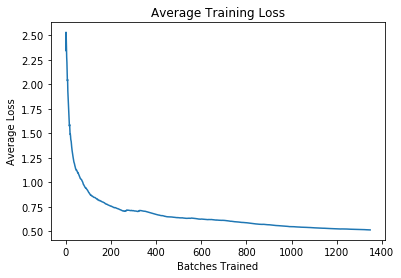

In [13]:
# plt.plot(range(len(loss_list)),loss_list)
# # plt.subplot(1,2,1)
# plt.xlabel("Batches Trained")
# plt.ylabel("Loss")
# plt.title("Training Loss")
# # plt.show()

# avg_list = []
# for i in range(1,len(loss_list)):
#     avg_list.append(sum(loss_list[:i])/(1.0*len(loss_list[:i])))
# # plt.subplot(1,2,2)
# plt.figure()
# plt.plot(range(len(avg_list)),avg_list)
# plt.xlabel("Batches Trained")
# plt.ylabel("Average Loss")
# plt.title("Average Training Loss")
# plt.show()